# Compile rate as a metric for student success

In [1]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import statistics
import sys
from scipy.stats import pearsonr
from scipy import stats
import seaborn as sns

In [2]:
# add the keystroke_analysis_utils folder of modules to be importable in the project
module_path = os.path.abspath(os.path.join('../keystroke_analysis_utils'))
if module_path in sys.path:
    sys.path.remove(module_path)

sys.path.append(str(module_path))

In [3]:
from assignment_keystrokes.analysis.assignment_metrics import create_assignment_df,\
    add_median_recoveries_above_threshold,\
    add_instance_length_stats

from assignment_keystrokes.analysis.instance_metrics import create_instance_df, add_recoveries_above_threshold_count

In [4]:
# plt.rcParams.update({'axes.labelsize': '16'})
plt.rcParams.update({'font.size': 16})

## Data Assumptions and Semantics

### Pipeline

Any file that didn't compile on the last event was thrown out in the data pipeline.
This was done to remove files that had some previously un-caught data integrity error.
There are probably some files that were mistakenly removed in order to remove problematic ones.

Questions:
- Should we consider only File.Edit events or all events? Consider all events for now.

In [5]:
events = pd.read_csv('../transformed_data/pipe_results.csv', low_memory=False)

In [6]:
events.head()

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,in_known_recovery,recovery_left,n_to_next_run,n_to_successful_run,next_event_type,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start
0,1902,1902,S001,p4s,task0.py,0.0,X-SwitchTask,NaN,NaN,NaN,...,False,0,9,9,File.Edit,0.047619,False,False,False,False
1,1903,1903,S001,p4s,task0.py,0.0,File.Edit,NaN,'''\n@@@@@@@@@@@@@\nAssignment#4\nThe task is ...,NaN,...,False,0,8,8,File.Edit,0.095238,False,NaN,False,False
2,1904,1904,S001,p4s,task0.py,0.0,File.Edit,space,,NaN,...,False,0,7,7,File.Edit,0.142857,False,NaN,False,False
3,1905,1905,S001,p4s,task0.py,0.0,File.Edit,T,T,NaN,...,False,0,6,6,File.Edit,0.190476,False,NaN,False,False
4,1906,1906,S001,p4s,task0.py,0.0,File.Edit,a,a,NaN,...,False,0,5,5,File.Edit,0.238095,False,NaN,False,False


In [7]:
students = pd.read_csv('../transformed_data/combine_students.csv')

In [8]:
students.head()

,Unnamed: 0,index,SubjectID,Group,SyntaxExercises,p4,p5,p6,p7,p8,...,Assign11,Assign12,Assign13,Exam1,Exam2,Exam3,FinalScore,Major,HighestACT,HighSchoolGPA
0,0,0,S275,Spring,False,100.0,100.0,95.0,96.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,S047,Spring,False,100.0,100.0,95.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,S503,Spring,False,100.0,100.0,100.0,95.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,S032,Spring,False,50.0,90.0,44.0,98.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,S032,Fall,True,98.0,100.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
students['Major'].value_counts().sum()

41

In [10]:
students['Major'].value_counts()

Computer Science                12
Mechanical Engineering           6
Non-Matriculated                 4
Statistics                       3
Physics                          2
Civil Engineering                2
Mathematics                      2
Preparatory Engineering - ME     2
Exploratory                      2
Math/Stats - Comp Teaching       1
Environmental Engineering        1
Sociology                        1
Art                              1
Biology                          1
Management                       1
Name: Major, dtype: int64

In [11]:
students['Major'].value_counts(normalize=True)

Computer Science                0.292683
Mechanical Engineering          0.146341
Non-Matriculated                0.097561
Statistics                      0.073171
Physics                         0.048780
Civil Engineering               0.048780
Mathematics                     0.048780
Preparatory Engineering - ME    0.048780
Exploratory                     0.048780
Math/Stats - Comp Teaching      0.024390
Environmental Engineering       0.024390
Sociology                       0.024390
Art                             0.024390
Biology                         0.024390
Management                      0.024390
Name: Major, dtype: float64

In [12]:
# convert some bool values to integers
events["compile_rate"] = events["would_compile"]*1

In [13]:
events["success_switch_rate"] = events["switch_to_success"]*1
events["fail_switch_rate"] = events["switch_to_fail"]*1

In [14]:
# bin events based on their place in tasks, to use for later run event analysis
num_bins = 10
bins = [x / num_bins for x in range(num_bins + 1)]
events['place_in_task_bin'] = pd.cut(events['place_in_task'], bins)

In [15]:
len(events.SubjectID.unique())

527

In [16]:
np.mean(events['compile_rate'])

0.5635841106118252

Collectively, the files compile after over half of all events.
This actually seems rather high, given that this is compiling after every keystroke.
However, perhaps this is reasonable since many errors in Python show up as runtime errors.

## Compile rate aggregations

### Compile rate for each file

Let us consider the compile rate for each file within each assignment for each student

In [17]:
file_grouped = events.groupby(['SubjectID', 'AssignmentID', 'CodeStateSection'])['compile_rate'].mean()

In [18]:
file_grouped.head(15)

SubjectID  AssignmentID  CodeStateSection
S001       p4s           task0.py            1.000000
                         task1.py            0.826087
           p5s           task0.py            0.989011
                         task1.py            0.804808
           p7s           task0.py            0.405568
                         task1.py            0.521895
S002       p4f           task0.py            1.000000
                         task1.py            0.517665
           p5f           task0.py            0.642157
                         task1.py            0.891979
           p6f           task0.py            0.916250
                         task1.py            0.672873
           p7f           task0.py            0.479279
                         task1.py            0.352241
           p8f           task0.py            0.607941
Name: compile_rate, dtype: float64

<AxesSubplot:>

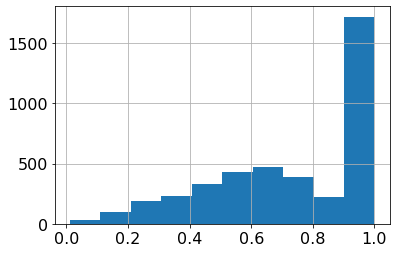

In [19]:
file_grouped.hist()

This graphic paints a much different picture of the compile rates than the overall average does.
In order for the average to overcome the large number of files that compiled nearly 100% of the time,
the number of events in 100% compile files must be much less than in some other files.

### Compile rate for each student

Given that the file-level compile rate doesn't seem to paint a very helpful picture of the data, let's try considering the compile rate at the student level

In [20]:
student_grouped = pd.DataFrame(events.groupby(['SubjectID'])['compile_rate']\
                               .mean())\
                                .reset_index()

In [21]:
print(len(student_grouped))
student_grouped.head(15)

527


,SubjectID,compile_rate
0,S001,0.529237
1,S002,0.538261
2,S003,0.513271
3,S004,0.596787
4,S005,0.537806
5,S006,0.636710
6,S007,0.147267
7,S008,0.996785
8,S009,0.698867
9,S011,0.618458


<AxesSubplot:>

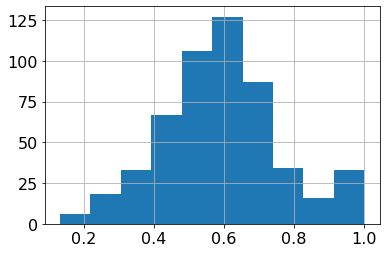

In [22]:
student_grouped.compile_rate.hist()

### Compile Rate per Assignment

In [23]:
assignment_grouped = events.groupby(['SubjectID', 'AssignmentID'])['compile_rate'].mean()
print(len(student_grouped))

527


1814


<AxesSubplot:>

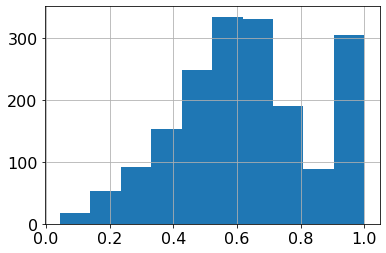

In [24]:
print(len(assignment_grouped))
assignment_grouped.hist()

To a degree, this comfirms our suspicions that there are specific files that diverge significantly from the overall trends of the assignment or of the student.

### Correlation of compile rate and file length

Now let us consider whether there is a relationship between how many events are in the file and the compile rate of that file

In [25]:
count_vs_mean = events.groupby(['SubjectID', 'AssignmentID', 'CodeStateSection'])['compile_rate'].agg(['count', 'mean'])
count_vs_mean.head(15)

count      mean
SubjectID AssignmentID CodeStateSection                 
S001      p4s          task0.py             21  1.000000
                       task1.py             23  0.826087
          p5s          task0.py             91  0.989011
                       task1.py           1040  0.804808
          p7s          task0.py           2658  0.405568
                       task1.py           2238  0.521895
S002      p4f          task0.py              1  1.000000
                       task1.py            651  0.517665
          p5f          task0.py            816  0.642157
                       task1.py            935  0.891979
          p6f          task0.py            800  0.916250
                       task1.py           2363  0.672873
          p7f          task0.py           5936  0.479279
                       task1.py           5042  0.352241
          p8f          task0.py           3803  0.607941

In [26]:
count_vs_mean_flat = count_vs_mean.reset_index()
count_vs_mean_flat.head()

,SubjectID,AssignmentID,CodeStateSection,count,mean
0,S001,p4s,task0.py,21,1.000000
1,S001,p4s,task1.py,23,0.826087
2,S001,p5s,task0.py,91,0.989011
3,S001,p5s,task1.py,1040,0.804808
4,S001,p7s,task0.py,2658,0.405568


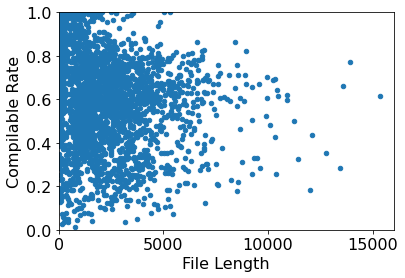

In [27]:
ax = count_vs_mean_flat.plot.scatter(x='count', y='mean', xlabel='File Length', ylabel='Compilable Rate',\
                                    xlim=(0, 16000), ylim=(0, 1.0))

In [28]:
ax.get_figure().savefig('./compilable_rate_vs_file_length.svg')

In [29]:
pearsonr(count_vs_mean_flat['count'], count_vs_mean_flat['mean'])

(-0.5204054119495933, 2.1145230612769496e-283)

This result is very quite significant.
The upper left corner of the plot is made by a significant number of short, perfectly compilable files.
Let us filter out the short files and re-test.

In [30]:
min_file_length = 1000
long_enough = count_vs_mean_flat[count_vs_mean_flat['count'] >= min_file_length]

In [31]:
pearsonr(long_enough['count'], long_enough['mean'])

(-0.06865717392243134, 0.0029425543825650777)

<AxesSubplot:xlabel='File Length', ylabel='Compile Rate'>

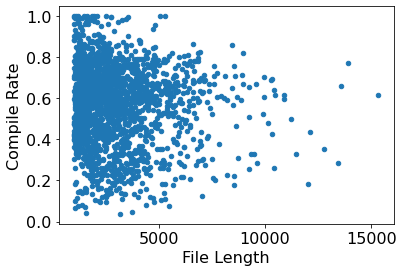

In [32]:
long_enough.plot.scatter(x='count', y='mean', xlabel='File Length', ylabel='Compile Rate')

## Compile Rate correlation with Student Outcomes

### Data preparation

In [33]:
combined_student = students.merge(student_grouped, on='SubjectID')

In [34]:
combined_student.head()

,Unnamed: 0,index,SubjectID,Group,SyntaxExercises,p4,p5,p6,p7,p8,...,Assign12,Assign13,Exam1,Exam2,Exam3,FinalScore,Major,HighestACT,HighSchoolGPA,compile_rate
0,0,0,S275,Spring,False,100.0,100.0,95.0,96.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.787007
1,1,1,S047,Spring,False,100.0,100.0,95.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.698110
2,2,2,S503,Spring,False,100.0,100.0,100.0,95.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.318945
3,3,3,S032,Spring,False,50.0,90.0,44.0,98.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.468195
4,4,4,S032,Fall,True,98.0,100.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.468195


In [35]:
combined_students_clean = combined_student.copy().dropna(subset=['compile_rate'])

### Course Final Score vs Compile Rate

In [36]:
final_score_present = combined_students_clean.dropna(subset=['FinalScore'])

In [37]:
combined_student.semester.unique()

array(['fall2019', 'fall2021'], dtype=object)

In [38]:
pearsonr(final_score_present['compile_rate'], final_score_present['FinalScore'])

(-0.0063481019927999465, 0.9689891346547219)

### Compile Rate vs Exam Average

In [39]:
exam_average_present = combined_students_clean.dropna(subset=['ExamAverage'])

In [40]:
pearsonr(exam_average_present['compile_rate'], exam_average_present['ExamAverage'])

(0.060102660364785086, 0.1631110920366151)

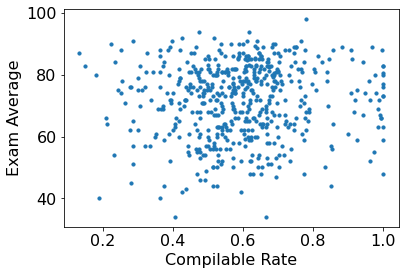

In [41]:
fig = exam_average_present.plot.scatter(x='compile_rate', y='ExamAverage',\
                                        xlabel='Compilable Rate', ylabel='Exam Average', s=10)

In [42]:
fig.get_figure().savefig(f'./semester_compile_rate_vs_exam.svg')

### Compile Rate vs Highest ACT Score

In [43]:
act_present = combined_students_clean.dropna(subset=['HighestACT'])

In [44]:
pearsonr(act_present['compile_rate'], act_present['HighestACT'])

(0.24841053857831577, 0.15659757722095893)

<AxesSubplot:xlabel='compile_rate', ylabel='HighestACT'>

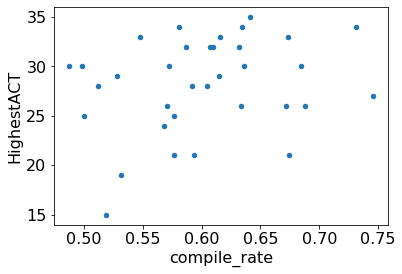

In [45]:
act_present.plot.scatter(x='compile_rate', y='HighestACT')

### Compile Rate vs High School GPA

In [46]:
hs_gpa_present = combined_students_clean.dropna(subset=['HighSchoolGPA'])

In [47]:
pearsonr(hs_gpa_present['compile_rate'], hs_gpa_present['HighSchoolGPA'])

(-0.09121570733625903, 0.6079151350614121)

<AxesSubplot:xlabel='compile_rate', ylabel='HighSchoolGPA'>

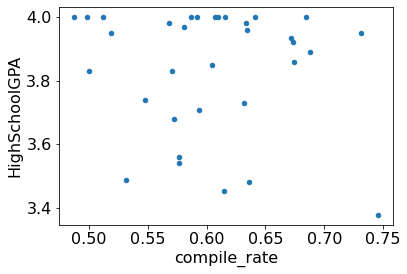

In [48]:
act_present.plot.scatter(x='compile_rate', y='HighSchoolGPA')

## The Squiggle Effect

Research question: does the presence of red squiggle underlines impact the student's compile rate?

In [49]:
group_2019 = events[events.semester == 'fall2019']
np.mean(group_2019['compile_rate'])

0.5540780988219868

In [50]:
group_2019.head()

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,next_event_type,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start,compile_rate,success_switch_rate,fail_switch_rate,place_in_task_bin
0,1902,1902,S001,p4s,task0.py,0.0,X-SwitchTask,NaN,NaN,NaN,...,File.Edit,0.047619,False,False,False,False,1,0,0,"(0.0, 0.1]"
1,1903,1903,S001,p4s,task0.py,0.0,File.Edit,NaN,'''\n@@@@@@@@@@@@@\nAssignment#4\nThe task is ...,NaN,...,File.Edit,0.095238,False,NaN,False,False,1,0,0,"(0.0, 0.1]"
2,1904,1904,S001,p4s,task0.py,0.0,File.Edit,space,,NaN,...,File.Edit,0.142857,False,NaN,False,False,1,0,0,"(0.1, 0.2]"
3,1905,1905,S001,p4s,task0.py,0.0,File.Edit,T,T,NaN,...,File.Edit,0.190476,False,NaN,False,False,1,0,0,"(0.1, 0.2]"
4,1906,1906,S001,p4s,task0.py,0.0,File.Edit,a,a,NaN,...,File.Edit,0.238095,False,NaN,False,False,1,0,0,"(0.2, 0.3]"


In [51]:
group_2021 = events[events.semester == 'fall2021']
np.mean(group_2021['compile_rate'])

0.5962734272687852

In [52]:
group_2021.head()

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,next_event_type,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start,compile_rate,success_switch_rate,fail_switch_rate,place_in_task_bin
4734412,0,0,Student1,Assign10,task1.py,NaN,File.Edit,NaN,# @@@@@@@@@@@@@\n# CS1400 - MW1\n# Assignment ??,NaN,...,File.Edit,0.007299,False,NaN,False,False,1,0,0,"(0.0, 0.1]"
4734413,1,1,Student1,Assign10,task1.py,NaN,File.Edit,NaN,\n,NaN,...,X-Action,0.014599,False,NaN,False,False,1,0,0,"(0.0, 0.1]"
4734414,2,2,Student1,Assign10,task1.py,NaN,X-Action,NaN,NaN,NaN,...,File.Edit,0.021898,False,NaN,False,False,1,0,0,"(0.0, 0.1]"
4734415,3,3,Student1,Assign10,task1.py,NaN,File.Edit,NaN,\n,NaN,...,X-Action,0.029197,False,NaN,False,False,1,0,0,"(0.0, 0.1]"
4734416,4,4,Student1,Assign10,task1.py,NaN,X-Action,NaN,NaN,NaN,...,X-Paste,0.036496,False,NaN,False,False,1,0,0,"(0.0, 0.1]"


Looking at the raw compile rates, there does seem to be some difference in the two groups.
Let's test to see if this is significant.

In [53]:
stats.ttest_ind(a=group_2019.compile_rate, b=group_2021.compile_rate, alternative='less')

Ttest_indResult(statistic=-87.92435394709433, pvalue=0.0)

In [54]:
stats.ttest_ind(a=group_2019.compile_rate, b=group_2021.compile_rate, equal_var=False, alternative='less')

Ttest_indResult(statistic=-88.55486945656588, pvalue=0.0)

### Student-level Squiggle Effect

Now, let's change the scope of our analysis to the student level

In [55]:
group_2021_students = group_2021.groupby(['SubjectID'])['compile_rate'].agg(['mean']).reset_index()
group_2019_students = group_2019.groupby(['SubjectID'])['compile_rate'].agg(['mean']).reset_index()

In [56]:
np.mean(group_2019_students['mean'])

0.5910924265214016

In [57]:
np.mean(group_2021_students['mean'])

0.6214902171332186

In [58]:
stats.ttest_ind(a=group_2019_students['mean'], b=group_2021_students['mean'], alternative='less')

Ttest_indResult(statistic=-1.1189298613331744, pvalue=0.1318408744564514)

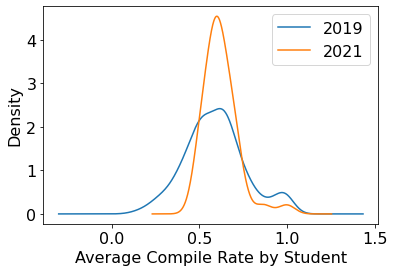

In [59]:
title="Distribution of students' average compile rate by year"
fig, ax = plt.subplots()
group_2019_students['mean'].plot.kde(label='2019', ax=ax)
group_2021_students['mean'].plot(kind='kde', ax=ax, label='2021', sharey=True)
ax.set_xlabel("Average Compile Rate by Student")
plt.legend()

In [60]:
ax.get_figure().savefig('./ide_impact.svg')

At first glance, this seems like a significant result!
By having the squiggles present in 2021, the students had a higher average compile rate than the students from 2019!

That might not be the whole picture.

In 2019, students were essentially forced to write all their code as a single file.
In 2021, they could, relatively easily, have multiple files as part of their project.
That means that the same code from 2019 that would have been in a single file originally might be split into two files in 2021.
This impacts the compile rate because splitting the same code into two files _might_ allow part of the code to compile even though the other part (in the other file) does **not** compile.

### Assignment-level Squiggle Effect

In [61]:
group_2021_assign = group_2021.groupby(['SubjectID', 'AssignmentID'])['compile_rate'].agg(['mean']).reset_index()
group_2019_assign = group_2019.groupby(['SubjectID', 'AssignmentID'])['compile_rate'].agg(['mean']).reset_index()

In [62]:
np.mean(group_2019_assign['mean'])

0.6278847221027611

In [63]:
np.mean(group_2021_assign['mean'])

0.6642850912095989

In [64]:
stats.ttest_ind(a=group_2019_assign['mean'], b=group_2021_assign['mean'])

Ttest_indResult(statistic=-2.41120181267088, pvalue=0.015998982440290452)

In [65]:
len(group_2019_assign)

1563

Concern - the squiggle effect is somewhat confounded by the auto-close-tag feature of PyCharm, which automatically adds in the closing parathesis or closing quotes when the opening paranthesis or opening quotes are added

Summary stats on how often a student uses multiple files in 2021
- Based on that result, potentially adjust to require all files in assignment to compile
- Stip out all the "o" events from runs.csv - we don't need the output

Distribution of compile rate per assignment for each student
- Student and assignment 
- Does the compile rate of assignment n predict the compile rate of assignment n + 1?

### How many files do most students use per assignment?

In [66]:
check_multi_file = group_2021.groupby(['SubjectID', 'AssignmentID'])['CodeStateSection'].nunique()

In [67]:
check_multi_file.head(15)

SubjectID  AssignmentID
Student1   Assign10         2
           Assign12         4
           Assign13         5
           Assign6          5
           Assign7          3
           Assign8          2
           Assign9          4
Student10  Assign10         7
           Assign11         9
           Assign12        13
           Assign6          2
           Assign7          3
           Assign8          3
           Assign9          5
Student11  Assign6          3
Name: CodeStateSection, dtype: int64

In [68]:
np.median(check_multi_file)

4.0

In [69]:
check_switches = events.groupby(['SubjectID', 'AssignmentID'])['success_switch_rate'].agg(['sum', 'mean']).reset_index()
check_switches.head(10)

,SubjectID,AssignmentID,sum,mean
0,S001,p4s,2,0.045455
1,S001,p5s,52,0.045977
2,S001,p7s,39,0.007966
3,S002,p4f,28,0.042945
4,S002,p5f,114,0.065106
5,S002,p6f,80,0.025292
6,S002,p7f,291,0.026508
7,S002,p8f,93,0.024454
8,S003,p4f,319,0.071142
9,S003,p5f,109,0.061547


In [70]:
check_switches[check_switches['AssignmentID'] == 'p8f'].head()

,SubjectID,AssignmentID,sum,mean
7,S002,p8f,93,0.024454
39,S012,p8f,177,0.028696
72,S020,p8f,91,0.021252
78,S023,p8f,165,0.011590
100,S029,p8f,55,0.026116


<AxesSubplot:>

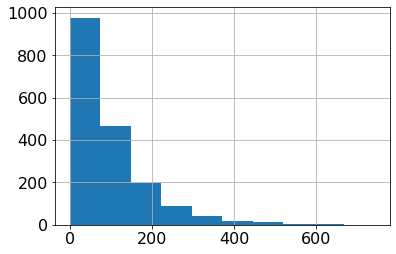

In [71]:
check_switches['sum'].hist()

In [72]:
events.groupby(['AssignmentID'])['success_switch_rate'].mean()

AssignmentID
Assign10    0.036903
Assign11    0.035744
Assign12    0.029239
Assign13    0.024716
Assign6     0.026343
Assign7     0.031714
Assign8     0.027740
Assign9     0.021977
p4f         0.041876
p4s         0.053646
p5f         0.045546
p5s         0.049312
p6f         0.024635
p6s         0.025894
p7f         0.015336
p7s         0.016727
p8f         0.020575
p8s         0.020844
Name: success_switch_rate, dtype: float64

In their article _Methods and Tools for Exploring Novice Compilation Behaviour_, Jadud agreed with Perkins et al in their categorization of students as stoppers, movers, and tinkerers.

Stoppers - encounter problem -> will give up or ask for help without working the problem through themselves 
Movers and Tinkerers -> will explore the problem—sometimes systematically, sometimes successfully—hopefully to keep moving towards a problem solution.

Error resolution strategy - "remove the error"

Methodology - only gathered snapshots of when students compiled their Java programs in the school computer labs

"we found it difficult to highlight behavioural similarities between students"

### Does the compile rate change based on whether the last run would compile?

In [73]:
last_run_would_compile = events[events.last_run_would_compile == True]
last_run_not_compile = events[events.last_run_would_compile == False]

In [74]:
print(np.mean(last_run_would_compile['compile_rate']))
print(np.mean(last_run_not_compile['compile_rate']))

0.5934815523460765
0.21546148594128237


In [75]:
print(len(last_run_would_compile))
print(len(last_run_not_compile))

5627843
483330


Length of recovery compared to how long until they next compile

Last x chars before uncompilable state or before uncompilable run
- Do certain characters often cause uncompilable runs?
- Do previous characters predict how long the recovery will take?
- Typing speed when they enter uncompilable state
- From the sequence, can we predict when the student is going to run their code?
- Do students pause before the run (to inspect their code or think about things) or immediately run?

Distance to furthest error in the program

## Variability in how often students run/compile their programs

In [76]:
run_events = events[events.EventType == 'Run.Program']

In [77]:
non_consec_runs = run_events[run_events.next_event_type != 'Run.Program']

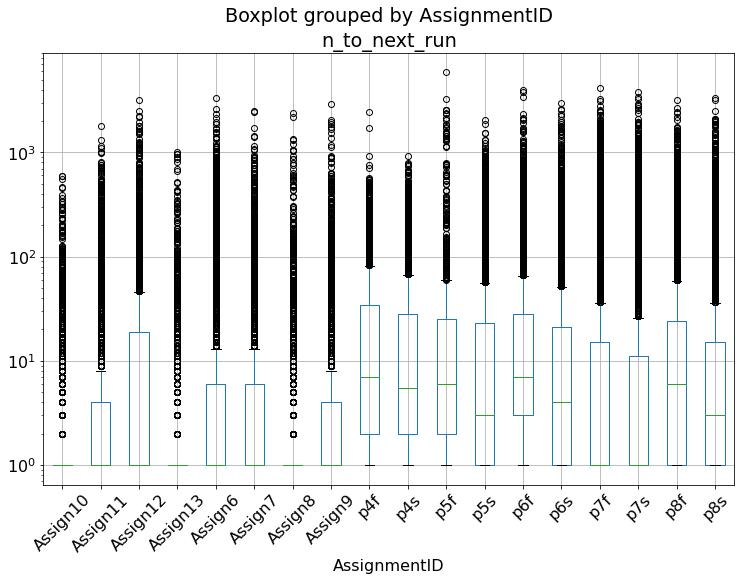

In [78]:
fig, ax = plt.subplots(figsize=(12,8))
run_events.boxplot(column='n_to_next_run', by='AssignmentID', ax=ax, rot=45)
ax.set_yscale('log')
plt.show()

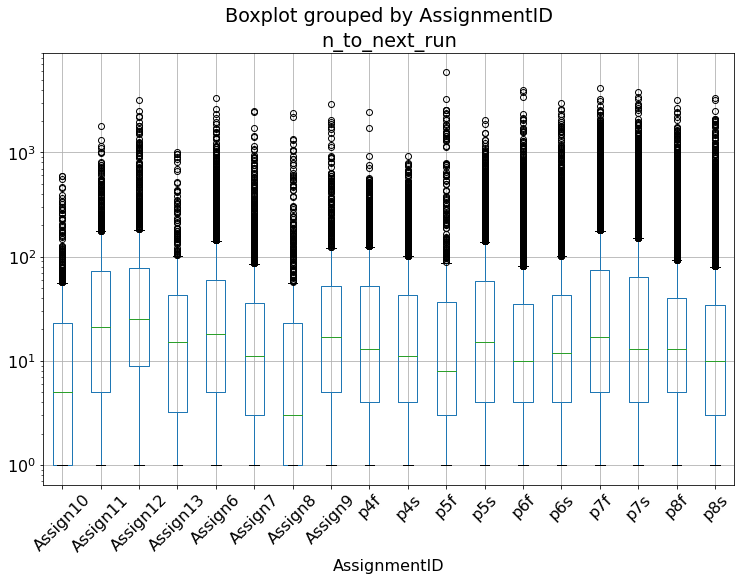

In [79]:
fig, ax = plt.subplots(figsize=(12,8))
non_consec_runs.boxplot(column='n_to_next_run', by='AssignmentID', ax=ax, rot=45)
ax.set_yscale('log')
plt.show()

In [80]:
# what percentage of all events are run events?
len(run_events) / len(events)

0.01751709532687096

In [81]:
len(non_consec_runs) / len(run_events)

0.5292666978047641

How far is it from most events to the next run?

In [82]:
statistics.mean(events.n_to_next_run)

537.146157865274

In [83]:
statistics.median(events.n_to_next_run)

228

How far is it generally from one run event to the next run event?

In [84]:
statistics.mean(run_events.n_to_next_run)

34.54942550210182

In [85]:
statistics.median(run_events.n_to_next_run)

2.0

In [86]:
statistics.mean(non_consec_runs.n_to_next_run)

64.38850647746126

In [87]:
statistics.median(non_consec_runs.n_to_next_run)

13.0

In [88]:
events.n_to_next_run.describe()

count    6.111173e+06
mean     5.371462e+02
std      7.519946e+02
min      1.000000e+00
25%      5.600000e+01
50%      2.280000e+02
75%      7.110000e+02
max      7.163000e+03
Name: n_to_next_run, dtype: float64

In [89]:
run_events.n_to_next_run.describe()

count    107050.000000
mean         34.549426
std         135.898524
min           1.000000
25%           1.000000
50%           2.000000
75%          14.000000
max        5882.000000
Name: n_to_next_run, dtype: float64

In [90]:
non_consec_runs.n_to_next_run.describe()

count    56658.000000
mean        64.388506
std        181.667651
min          1.000000
25%          4.000000
50%         13.000000
75%         46.000000
max       5882.000000
Name: n_to_next_run, dtype: float64

In [91]:
compilable_runs = run_events[run_events.last_run_would_compile == True]
uncompilable_runs = run_events[run_events.last_run_would_compile == False]

In [92]:
compilable_runs.n_to_next_run.describe()

count    92124.000000
mean        35.235498
std        138.272403
min          1.000000
25%          1.000000
50%          1.000000
75%         13.000000
max       5882.000000
Name: n_to_next_run, dtype: float64

In [93]:
uncompilable_runs.n_to_next_run.describe()

count    14926.000000
mean        30.314954
std        120.131237
min          1.000000
25%          2.000000
50%          5.000000
75%         17.000000
max       4165.000000
Name: n_to_next_run, dtype: float64

In [94]:
events.columns

Index(['unnamed_zero', 'EventID', 'SubjectID', 'AssignmentID',
       'CodeStateSection', 'X-Task', 'EventType', 'X-Keystroke', 'InsertText',
       'DeleteText', 'SourceLocation', 'ClientTimestamp', 'EditType',
       'X-RunInput', 'X-RunOutput', 'X-RunHasError', 'X-RunUserTerminated',
       'X-RawAssignmentID', 'X-Term', 'X-Compilable', 'semester', 'X-Metadata',
       'ToolInstances', 'CodeStateID', 'would_compile', 'error_message',
       'switch_to_success', 'switch_to_fail', 'last_run_would_compile',
       'in_known_recovery', 'recovery_left', 'n_to_next_run',
       'n_to_successful_run', 'next_event_type', 'place_in_task',
       'run_before_recovery_known', 'run_before_recovery_unknown',
       'known_recovery_start', 'recovery_start', 'compile_rate',
       'success_switch_rate', 'fail_switch_rate', 'place_in_task_bin'],
      dtype='object')

In [95]:
events['binary_run'] = pd.get_dummies(events['EventType'])['Run.Program']

In [96]:
events.head()

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start,compile_rate,success_switch_rate,fail_switch_rate,place_in_task_bin,binary_run
0,1902,1902,S001,p4s,task0.py,0.0,X-SwitchTask,NaN,NaN,NaN,...,0.047619,False,False,False,False,1,0,0,"(0.0, 0.1]",0
1,1903,1903,S001,p4s,task0.py,0.0,File.Edit,NaN,'''\n@@@@@@@@@@@@@\nAssignment#4\nThe task is ...,NaN,...,0.095238,False,NaN,False,False,1,0,0,"(0.0, 0.1]",0
2,1904,1904,S001,p4s,task0.py,0.0,File.Edit,space,,NaN,...,0.142857,False,NaN,False,False,1,0,0,"(0.1, 0.2]",0
3,1905,1905,S001,p4s,task0.py,0.0,File.Edit,T,T,NaN,...,0.190476,False,NaN,False,False,1,0,0,"(0.1, 0.2]",0
4,1906,1906,S001,p4s,task0.py,0.0,File.Edit,a,a,NaN,...,0.238095,False,NaN,False,False,1,0,0,"(0.2, 0.3]",0


<AxesSubplot:label='1630553a-03f7-4a9e-97df-51d9a92e6e55'>

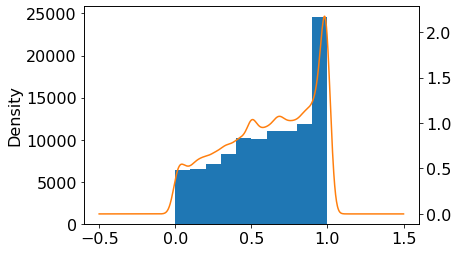

In [97]:
ax = run_events.place_in_task.plot.hist()
run_events.place_in_task.plot(kind='kde', ax=ax, secondary_y=True)

<AxesSubplot:label='bcf75d3e-a7ea-4252-8154-47db9a613ddd'>

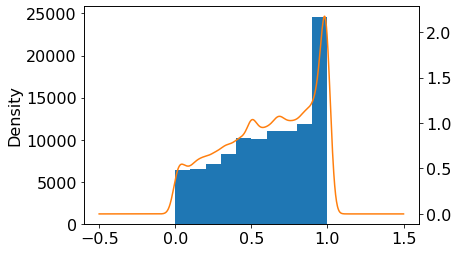

In [98]:
ax = run_events.place_in_task.plot.hist()
run_events.place_in_task.plot(kind='kde', ax=ax, secondary_y=True)

In [99]:
print(len(run_events))
print(len(compilable_runs))
print(len(uncompilable_runs))
print(len(uncompilable_runs) / len(run_events))

107050
92124
14926
0.1394301728164409


<AxesSubplot:ylabel='Frequency'>

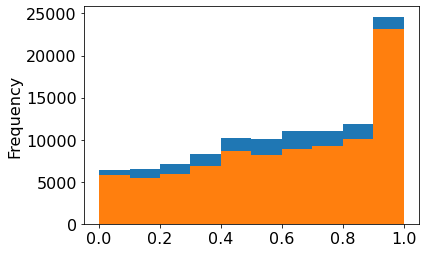

In [100]:
ax = run_events.place_in_task.plot.hist()
compilable_runs.place_in_task.plot.hist(ax=ax, sharey=True)

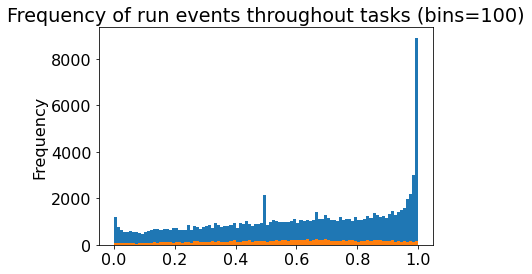

In [101]:
num_bins = 100
title=f'Frequency of run events throughout tasks (bins={num_bins})'
ax = run_events.place_in_task.plot.hist(bins=num_bins)
fig = uncompilable_runs.place_in_task.plot.hist(ax=ax, bins=num_bins, sharey=True, sharex=True, title=title)

In [102]:
run_events.head()

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,next_event_type,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start,compile_rate,success_switch_rate,fail_switch_rate,place_in_task_bin
9,1914,1915,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,Run.Program,0.476190,False,NaN,False,False,1,0,0,"(0.4, 0.5]"
10,1933,1934,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,Run.Program,0.523810,False,NaN,False,False,1,0,0,"(0.5, 0.6]"
11,1934,1935,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,X-SwitchTask,0.571429,False,NaN,False,False,1,0,0,"(0.5, 0.6]"
18,1941,1943,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,X-SwitchTask,0.904762,False,NaN,False,False,1,0,0,"(0.9, 1.0]"
45,1946,1950,S001,p5s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,File.Edit,0.021978,False,NaN,False,False,1,0,0,"(0.0, 0.1]"


In [103]:
grouped_compilable_runs = compilable_runs.groupby(['place_in_task_bin'])['compile_rate']\
    .agg(['mean', 'count']).reset_index().rename({'count': 'compilable_run_count'}, axis='columns')

In [104]:
grouped_uncompilable_runs = uncompilable_runs.groupby(['place_in_task_bin'])['compile_rate']\
    .agg(['mean', 'count']).reset_index().rename({'count': 'uncompilable_run_count'}, axis='columns')

In [105]:
grouped_run_events = grouped_compilable_runs.merge(grouped_uncompilable_runs, on='place_in_task_bin')
grouped_run_events['proportion_runs_compilable'] = grouped_run_events['compilable_run_count']\
    / (grouped_run_events['compilable_run_count'] + grouped_run_events['uncompilable_run_count'])

In [106]:
grouped_run_events.head()
# next step: group all events, calculate the proportion of events that are compilable

,place_in_task_bin,mean_x,compilable_run_count,mean_y,uncompilable_run_count,proportion_runs_compilable
0,"(0.0, 0.1]",1.0,5742,0.0,707,0.890371
1,"(0.1, 0.2]",1.0,5470,0.0,984,0.847536
2,"(0.2, 0.3]",1.0,5909,0.0,1183,0.833192
3,"(0.3, 0.4]",1.0,6832,0.0,1483,0.821648
4,"(0.4, 0.5]",1.0,8602,0.0,1557,0.846737


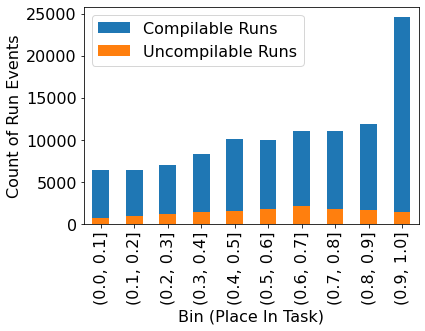

In [107]:
ax = grouped_run_events.plot.bar(x='place_in_task_bin', y=['uncompilable_run_count', 'compilable_run_count'], stacked=True,\
                            xlabel='Bin (Place In Task)', ylabel='Count of Run Events',\
                           color=['tab:orange', 'tab:blue'])



handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
labels[0] = 'Compilable Runs'
labels[1] = 'Uncompilable Runs'
ax.legend(handles,labels,loc=2, prop={'size': 16})

In [108]:
ax.get_figure().savefig('./distribution_of_runs_10_bins.svg')

In [109]:
[x for x in events['place_in_task_bin'].unique()]

[Interval(0.0, 0.1, closed='right'),
 Interval(0.1, 0.2, closed='right'),
 Interval(0.2, 0.3, closed='right'),
 Interval(0.3, 0.4, closed='right'),
 Interval(0.4, 0.5, closed='right'),
 Interval(0.5, 0.6, closed='right'),
 Interval(0.6, 0.7, closed='right'),
 Interval(0.7, 0.8, closed='right'),
 Interval(0.8, 0.9, closed='right'),
 Interval(0.9, 1.0, closed='right')]

<AxesSubplot:title={'center':'Aggregate Propertion of Run Events that Would Compile'}, xlabel='Binned location in task (bins = 10)', ylabel='Percent of run events that would compile'>

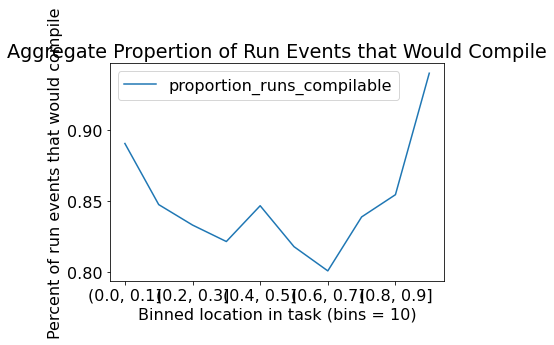

In [110]:
grouped_run_events.plot.line(x='place_in_task_bin', y='proportion_runs_compilable',\
                            title='Aggregate Propertion of Run Events that Would Compile',\
                            xlabel='Binned location in task (bins = 10)',\
                            ylabel='Percent of run events that would compile',\
                            )

In [111]:
fig.get_figure().savefig('./proportion_runs_compilable.svg')

In [112]:
grouped_binned_events = events.groupby(['place_in_task_bin'])['compile_rate']\
    .agg(['mean', 'count']).reset_index()\
    .rename({'count': 'compilable_event_count', 'mean': 'average_bin_compile_rate'}, axis='columns')

In [113]:
grouped_binned_events.head()

,place_in_task_bin,average_bin_compile_rate,compilable_event_count
0,"(0.0, 0.1]",0.607752,607682
1,"(0.1, 0.2]",0.536708,610718
2,"(0.2, 0.3]",0.517302,610355
3,"(0.3, 0.4]",0.508259,611175
4,"(0.4, 0.5]",0.499039,613477


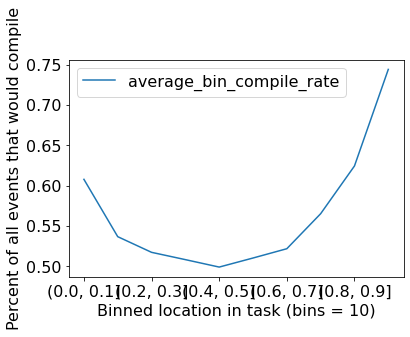

In [114]:
ax = grouped_binned_events.plot.line(x='place_in_task_bin', y='average_bin_compile_rate',\
                               xlabel='Binned location in task (bins = 10)',\
                               ylabel='Percent of all events that would compile')

In [115]:
ax.get_figure().savefig('./proportion_events_compilable.svg')

Together, these charts show that, towards the end of the task, the number of run events goes up, the compile rate of runs goes up, and the compile rate of overall events goes up.

Is the probability that an event would compile related to whether it is a run event?

In [116]:
print(events['would_compile'].mean())
print(run_events['would_compile'].mean())

0.5635841106118252
0.8605698271835591


In [117]:
# TODO separate the two years, compare and contrast for these numbers

In [118]:
run_events_with_error_col = run_events[run_events['X-RunHasError'].notnull()]

In [119]:
run_events_with_error_col['AssignmentID'].unique()

array(['p4f', 'p5f', 'p6f', 'p7f', 'p8f'], dtype=object)

In [120]:
runtime_errors = run_events_with_error_col[run_events_with_error_col['X-RunHasError'] == True]

In [121]:
print(len(run_events_with_error_col))
print(len(runtime_errors))
print(len(runtime_errors) / len(run_events_with_error_col))

29400
10057
0.3420748299319728


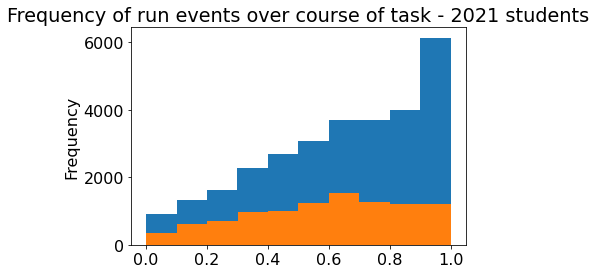

In [122]:
ax = run_events_with_error_col.place_in_task.plot.hist()
fig = runtime_errors.place_in_task.plot.hist(ax=ax, sharey=True, sharex=True,
                                             title="Frequency of run events over course of task - 2021 students" )

In [123]:
fig.get_figure().savefig('./runs_vs_runtime_errors.svg')

In [124]:
bins = 10

cut_run_events = pd.cut(run_events.place_in_task, bins=bins)
cut_run_events.head()

9           (0.4, 0.5]
10          (0.5, 0.6]
11          (0.5, 0.6]
18          (0.9, 1.0]
45    (-0.000895, 0.1]
Name: place_in_task, dtype: category
Categories (10, interval[float64, right]): [(-0.000895, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]

In [125]:
cut_run_events

9                (0.4, 0.5]
10               (0.5, 0.6]
11               (0.5, 0.6]
18               (0.9, 1.0]
45         (-0.000895, 0.1]
                 ...       
6111165          (0.9, 1.0]
6111166          (0.9, 1.0]
6111167          (0.9, 1.0]
6111168          (0.9, 1.0]
6111169          (0.9, 1.0]
Name: place_in_task, Length: 107050, dtype: category
Categories (10, interval[float64, right]): [(-0.000895, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]

In [126]:
# TODO:
# - Add legend
# - Add both figures to Overleaf document
# - Look into adding percents to bars on the last 3 charts
# - Throw out students who have less than 100 events in their task 
# - Fix sorting when it is incorrect

## TODO
- [ ] Add a start on the label of turtle assignments
- [x] Create one that has consecutive runs discarded (only keep consecutive runs if the file was modified in between runs)
- [ ] Divide events stream into 3 blocks - opening behavior, middle game, end game 
  - Hypothesis: the end game becomes more fine-tuning, resulting in more frequent run events
- Quantify how meticulous students are - can we categorize Test Driven Development-like behavior? 
- Development process of a program as an event line - probability distribution of a run event happening - continuous version of the 3 blocks idea - probability density function 
- Probability of re-running given it (a) compiled or (b) didn't compile
- Does the number of events between runs vary per assignment or per student vary in a statistically significant way?
  - Kruskall-Wallis, Mann-Whitney U
- Split assignments into tasks

TODO here:
- [x] y-axis on log scale
- [ ] Get additional student outcome data from [the public data repository](TODO link here)
- [ ] Categorizing students based on how many events they have, on average, before the next
  - [ ] Run
  - [ ] Compilable event
- [ ] Ignore consecutive runs that are less than some threshold
or
- [ ] Ignore consecutive runs where the code didn't change that much from the last run (need some similarity score for code)
- Idea, might not be worth the time: Between runs, count number of events and code similarity score, determine change in similarity per number of keystrokes

## Known Recoveries 

A Known Recovery begins with an uncompilable run and ends with the first event where the snapshot compiles successfully.

In [127]:
events[(events['last_run_would_compile'] == True) & (events['EventType'] == 'Run.Program')]

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start,compile_rate,success_switch_rate,fail_switch_rate,place_in_task_bin,binary_run
9,1914,1915,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0.476190,False,NaN,False,False,1,0,0,"(0.4, 0.5]",1
10,1933,1934,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0.523810,False,NaN,False,False,1,0,0,"(0.5, 0.6]",1
11,1934,1935,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0.571429,False,NaN,False,False,1,0,0,"(0.5, 0.6]",1
18,1941,1943,S001,p4s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0.904762,False,NaN,False,False,1,0,0,"(0.9, 1.0]",1
45,1946,1950,S001,p5s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0.021978,False,NaN,False,False,1,0,0,"(0.0, 0.1]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6111165,1998593,1998593,Student8,Assign9,task2.py,NaN,Run.Program,NaN,NaN,NaN,...,0.951807,False,NaN,False,False,1,0,0,"(0.9, 1.0]",1
6111166,1998594,1998594,Student8,Assign9,task2.py,NaN,Run.Program,NaN,NaN,NaN,...,0.963855,False,NaN,False,False,1,0,0,"(0.9, 1.0]",1
6111167,1998595,1998595,Student8,Assign9,task2.py,NaN,Run.Program,NaN,NaN,NaN,...,0.975904,False,NaN,False,False,1,0,0,"(0.9, 1.0]",1
6111168,1998596,1998596,Student8,Assign9,task2.py,NaN,Run.Program,NaN,NaN,NaN,...,0.987952,False,NaN,False,False,1,0,0,"(0.9, 1.0]",1


In [128]:
run_events = events[events.EventType == 'Run.Program']
# unknown_recovery_starts = events[events.switch_to_fail == True]
last_run_would_compile = run_events[run_events.last_run_would_compile == True]
known_recovery_starts = last_run_would_compile[last_run_would_compile.would_compile == False]

In [129]:
events.head()

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,place_in_task,run_before_recovery_known,run_before_recovery_unknown,known_recovery_start,recovery_start,compile_rate,success_switch_rate,fail_switch_rate,place_in_task_bin,binary_run
0,1902,1902,S001,p4s,task0.py,0.0,X-SwitchTask,NaN,NaN,NaN,...,0.047619,False,False,False,False,1,0,0,"(0.0, 0.1]",0
1,1903,1903,S001,p4s,task0.py,0.0,File.Edit,NaN,'''\n@@@@@@@@@@@@@\nAssignment#4\nThe task is ...,NaN,...,0.095238,False,NaN,False,False,1,0,0,"(0.0, 0.1]",0
2,1904,1904,S001,p4s,task0.py,0.0,File.Edit,space,,NaN,...,0.142857,False,NaN,False,False,1,0,0,"(0.1, 0.2]",0
3,1905,1905,S001,p4s,task0.py,0.0,File.Edit,T,T,NaN,...,0.190476,False,NaN,False,False,1,0,0,"(0.1, 0.2]",0
4,1906,1906,S001,p4s,task0.py,0.0,File.Edit,a,a,NaN,...,0.238095,False,NaN,False,False,1,0,0,"(0.2, 0.3]",0


In [130]:
events['known_recovery'] = 0

In [131]:
events['ktest'] = (events.would_compile != events.shift(1).would_compile) & (events.SubjectID == events.shift(1).SubjectID)
events['ktest2'] = events['ktest'] * 1

In [132]:
events['ktest3'] = events['ktest2'].cumsum()

In [133]:
uncompilables = events[events.would_compile == False].copy()

In [134]:
krun_events = uncompilables[uncompilables['EventType'] == 'Run.Program']

In [135]:
df3 = krun_events.groupby('ktest3').agg({ 'ktest3': ['first', 'count'], 'SubjectID': 'first', 'semester': 'first', 'AssignmentID': 'first', 'CodeStateSection': 'first'})


In [136]:
df3.columns = ['id', 'num_runs', 'SubjectID', 'semester', 'assignID', 'file']

In [137]:
df3['more_than_one_run'] = (df3['num_runs'] != 1) * 1

In [138]:
df3[df3.semester == 'fall2021'].tail(20)

,id,num_runs,SubjectID,semester,assignID,file,more_than_one_run
ktest3,,,,,,,
323312,323312,2,Student44,fall2021,Assign6,task2.py,1
323350,323350,2,Student44,fall2021,Assign6,task2.py,1
323480,323480,2,Student44,fall2021,Assign6,task1.py,1
324540,324540,4,Student5,fall2021,Assign12,task1.py,1
325390,325390,2,Student6,fall2021,Assign12,task2.py,1
326472,326472,2,Student7,fall2021,Assign12,task1.py,1
326890,326890,3,Student7,fall2021,Assign12,task3.py,1
327350,327350,2,Student7,fall2021,Assign7,chessboard.py,1
328268,328268,2,Student8,fall2021,Assign10,junkW2.py,1


In [139]:
df4 = df3.groupby('SubjectID').agg({ 'more_than_one_run': ['count', 'sum'], 'semester': 'first'})

In [140]:
df4.columns = ['num_recoveries', 'more_than_one_run', 'semester']

In [141]:
df4['average'] = df4['more_than_one_run'] / df4['num_recoveries']

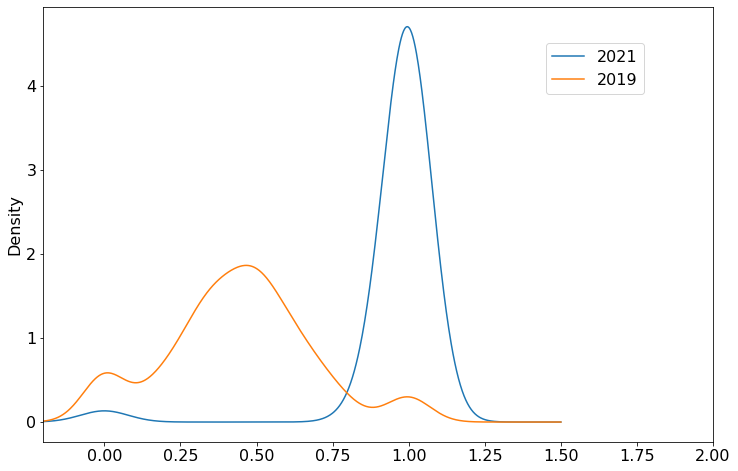

In [142]:
x_min = -0.2
x_max = 2
avg_2021_krun_in_recovery = df4[df4['semester'] == 'fall2021']['average']
avg_2019_krun_in_recovery = df4[df4['semester'] == 'fall2019']['average']
fig, ax = plt.subplots(figsize=(12,8))
avg_2021_krun_in_recovery.plot.kde(ax=ax, label='2021', xlim=(x_min, x_max))
plt.legend()
avg_2019_krun_in_recovery.plot.kde(label='2019', sharey=True, ax=ax, xlim=(x_min, x_max))
plt.legend(loc=(0.75, 0.8))

In [143]:
stats.ttest_ind(a=avg_2021_krun_in_recovery, b=avg_2019_krun_in_recovery, equal_var=False, alternative='less')


Ttest_indResult(statistic=18.131531656989505, pvalue=1.0)

In [144]:
avg_2021_krun_in_recovery.mean()

0.9647786078580936

In [145]:
avg_2019_krun_in_recovery.mean()

0.44079890610421657

In [146]:
ax.get_figure().savefig('./dist_krun_in_recovery.svg')

In [147]:
events['test'] = (events.would_compile != events.shift(1).would_compile) & (events.SubjectID == events.shift(1).SubjectID)
events['test2'] = events['test'] * 1

In [148]:
events['test3'] = events['test2'].cumsum()

In [149]:
uncompilables = events[events.would_compile == False].copy()

In [150]:
uncompilables['test4'] = (uncompilables['EventType'] == 'Run.Program') * 1

In [151]:
df = uncompilables.groupby('test3').agg({ 'test4': 'sum', 'SubjectID': 'first', 'semester': 'first'})

In [152]:
df['runs_in_recovery'] = (df['test4'] > 0) * 1

In [153]:
df.runs_in_recovery.unique()

array([0, 1])

In [154]:
df2 = df.groupby('SubjectID').agg({ 'runs_in_recovery': ['count', 'sum'], 'semester': 'first'})

In [155]:
df2.columns = df2.columns.get_level_values(1)

In [156]:
df2.head()

,count,sum,first
SubjectID,,,
S001,93,3,fall2019
S002,602,29,fall2019
S003,543,3,fall2019
S004,561,4,fall2019
S005,336,3,fall2019


In [157]:
df2['average'] = df2['sum'] / df2['count']

<AxesSubplot:xlabel='average', ylabel='Density'>

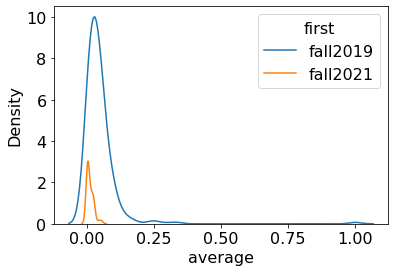

In [158]:
sns.kdeplot(data=df2, x='average', hue='first', common_norm=True)

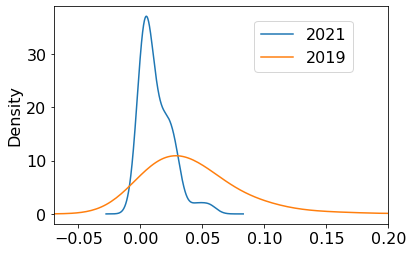

In [159]:
x_min = -0.07
x_max = 0.2
avg_2021_run_in_recovery = df2[df2['first'] == 'fall2021']['average']
avg_2019_run_in_recovery = df2[df2['first'] == 'fall2019']['average']
fig, ax = plt.subplots(figsize=(6,4))
avg_2021_run_in_recovery.plot.kde(ax=ax, label='2021', xlim=(x_min, x_max))
plt.legend()
avg_2019_run_in_recovery.plot.kde(label='2019', sharey=True, ax=ax, xlim=(x_min, x_max))
plt.legend(loc=(0.6, 0.7))

In [160]:
stats.ttest_ind(a=avg_2021_run_in_recovery, b=avg_2019_run_in_recovery, equal_var=False, alternative='less')


Ttest_indResult(statistic=-8.791942047783666, pvalue=2.4582529526011225e-17)

In [161]:
print(avg_2021_run_in_recovery.mean())
print(avg_2019_run_in_recovery.mean())

0.012652180141795196
0.04778296322401554


In [162]:
ax.get_figure().savefig('./dist_run_in_recovery.svg')

In [163]:
# known recovery

In [164]:
len(df)

165622

In [165]:
# print(f"uncompilable run to recovery mean: {np.mean(unknown_recovery_starts.recovery_left)}")
# print(f"uncompilable run to recovery median: {np.median(unknown_recovery_starts.recovery_left)}")

In [166]:
uncompilable_runs_2019 = uncompilable_runs[uncompilable_runs.semester == 'fall2019']
uncompilable_runs_2021 = uncompilable_runs[uncompilable_runs.semester == 'fall2021']

In [167]:
x_min = 0
x_max = 2000
y_min = 0
y_max = 2000

line = np.linspace(start=x_min, stop=x_max, num=100)
second_y = [x * 2 for x in line]

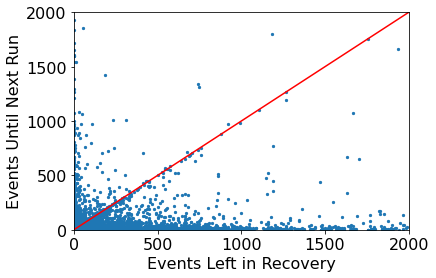

In [168]:
ax = uncompilable_runs.plot.scatter(x='recovery_left', \
                            y='n_to_next_run', \
                            xlabel='Events Left in Recovery', \
                            ylabel='Events Until Next Run', \
                            xlim=(x_min, x_max),\
                            ylim=(y_min, y_max),\
                            s=5,\
                            )
plt.plot(line, line, '-r', label='y=x')

In [169]:
ax.get_figure().savefig('./known_recovery_vs_run_python.svg', bbox_inches='tight')

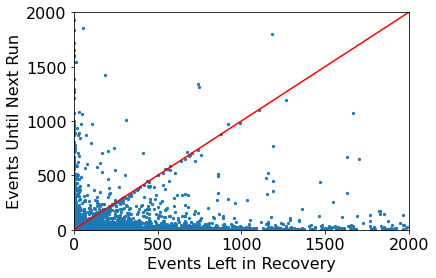

In [170]:
ax = uncompilable_runs_2019.plot.scatter(x='recovery_left', \
                            y='n_to_next_run', \
                            xlabel='Events Left in Recovery', \
                            ylabel='Events Until Next Run', \
                            xlim=(x_min, x_max),\
                            ylim=(y_min, y_max),\
                            s=5,\
                            )
plt.plot(line, line, '-r', label='y=x')

In [171]:
ax.get_figure().savefig('./known_recovery_vs_run_2019.png', bbox_inches='tight')

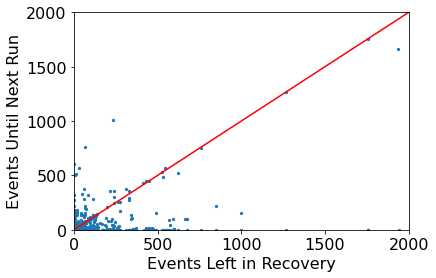

In [172]:
ax = uncompilable_runs_2021.plot.scatter(x='recovery_left', \
                            y='n_to_next_run', \
                            xlabel='Events Left in Recovery', \
                            ylabel='Events Until Next Run', \
                            xlim=(x_min, x_max),\
                            ylim=(y_min, y_max),\
                            s=5,\
                            )
plt.plot(line, line, '-r', label='y=x')

In [173]:
ax.get_figure().savefig('./known_recovery_vs_run_2021.png', bbox_inches='tight')

In [174]:
def calc_rel_to_line(df, well_above_threshold=1.5):
    local_df = df.copy()
    local_df['above_line'] = local_df['n_to_next_run'] / local_df['recovery_left']
    total = len(df)
    well_above_line   = len(local_df[local_df['above_line'] > well_above_threshold])
    slight_above_mask = (local_df['above_line'] <= well_above_threshold) & (local_df['above_line'] > 1)
    slight_above_line = len(local_df[slight_above_mask])
    below_line        = len(local_df[local_df['above_line'] <= 1])
                                     
    print(f'Well above the line (m > {well_above_threshold}):', well_above_line, well_above_line / total)
    print(f'Slightly above the line (1 < m <= {well_above_threshold}):', slight_above_line, slight_above_line / total)
    print('Below the line (m < 1):', below_line, below_line / total)

In [175]:
print('All data: ')
calc_rel_to_line(uncompilable_runs)
print('----------')
print('2019 data: ')
calc_rel_to_line(uncompilable_runs_2019)
print('----------')
print('2021 data: ')
calc_rel_to_line(uncompilable_runs_2021)

All data: 
Well above the line (m > 1.5): 3598 0.24105587565322256
Slightly above the line (1 < m <= 1.5): 1632 0.10933940774487472
Below the line (m < 1): 9696 0.6496047166019027
----------
2019 data: 
Well above the line (m > 1.5): 3344 0.24847674245801754
Slightly above the line (1 < m <= 1.5): 1466 0.10893149056323377
Below the line (m < 1): 8648 0.6425917669787486
----------
2021 data: 
Well above the line (m > 1.5): 254 0.17302452316076294
Slightly above the line (1 < m <= 1.5): 166 0.11307901907356949
Below the line (m < 1): 1048 0.7138964577656676


In [176]:
uncompilable_runs_cp = uncompilable_runs.copy()

In [177]:
uncompilable_runs_cp['recovery_vs_run'] =  uncompilable_runs_cp['n_to_next_run'] / uncompilable_runs_cp['recovery_left']
uncompilable_runs_cp['above_line'] =  uncompilable_runs_cp['n_to_next_run'] / uncompilable_runs_cp['recovery_left'] > 1

In [178]:
subject_known_recovery = uncompilable_runs_cp.groupby('SubjectID')['above_line'].agg(['mean']) \
    .reset_index()\
    .rename({'mean': 'recovery_ratio'}, axis='columns') \
    .merge(students, on='SubjectID') \
    .dropna(subset=['ExamAverage']) 

In [179]:
known_recovery_2019 = subject_known_recovery[subject_known_recovery['semester'] == 'fall2019']
known_recovery_2021 = subject_known_recovery[subject_known_recovery['semester'] == 'fall2021']

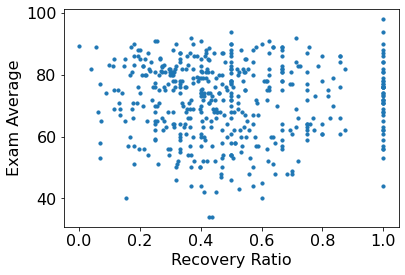

In [180]:
ax = subject_known_recovery.plot.scatter(x='recovery_ratio', y='ExamAverage', \
                                         xlabel='Recovery Ratio', ylabel='Exam Average',\
                                         s=10)

In [181]:
ax.get_figure().savefig('./known_recovery_ratio.png', bbox_inches='tight')

In [182]:
print('Known recovery all data')
print(pearsonr(subject_known_recovery['recovery_ratio'], subject_known_recovery['ExamAverage']))
print('------')
print('Known recovery 2019 data')
print(pearsonr(known_recovery_2019['recovery_ratio'], known_recovery_2019['ExamAverage']))
print('------')
print('Known recovery 2021 data')
print(pearsonr(known_recovery_2021['recovery_ratio'], known_recovery_2021['ExamAverage']))

Known recovery all data
(-0.01560033969121432, 0.732898281776461)
------
Known recovery 2019 data
(0.021865679253161175, 0.645505692475038)
------
Known recovery 2021 data
(-0.14555014991484738, 0.39699263866283785)


In [183]:
stats.ttest_ind(a=known_recovery_2021.recovery_ratio, b=group_2019.compile_rate, equal_var=False, alternative='less')

Ttest_indResult(statistic=-7.471131944334788, pvalue=4.755603369338194e-09)

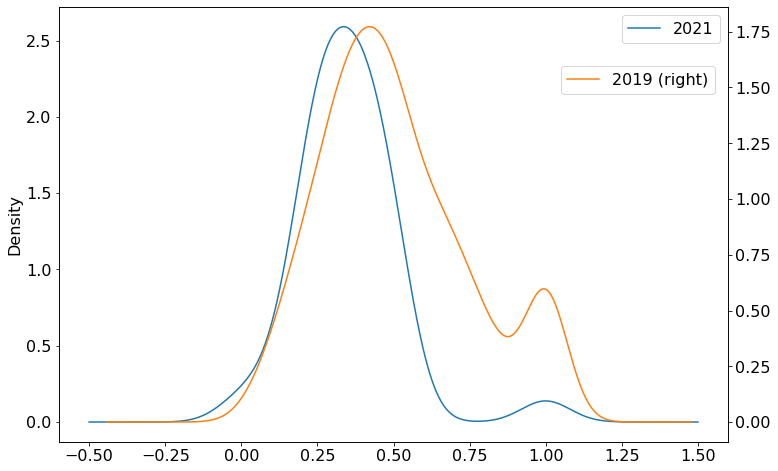

In [184]:
fig, ax = plt.subplots(figsize=(12,8))
known_recovery_2021['recovery_ratio'].plot.kde(ax=ax, label='2021')
plt.legend()
known_recovery_2019['recovery_ratio'].plot.kde(label='2019', secondary_y=True, ax=ax)
plt.legend(loc=(0.75, 0.8))

In [185]:
ax.get_figure().savefig('./recovery_ratio_by_year.svg')

In [186]:
print(len(events[ (events['last_run_would_compile'] == False) & (events['EventType'] == 'Run.Program') & (events['would_compile'] == False) ]))
print(len(events))
events[ (events['last_run_would_compile'] == False) & (events['EventType'] == 'Run.Program') & (events['would_compile'] == False) ].head()

14926
6111173


,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,fail_switch_rate,place_in_task_bin,binary_run,known_recovery,ktest,ktest2,ktest3,test,test2,test3
620,2485,2501,S001,p5s,task1.py,1.0,Run.Program,NaN,NaN,NaN,...,0,"(0.4, 0.5]",1,0,False,0,47,False,0,47
2567,4468,8285,S001,p7s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0,"(0.5, 0.6]",1,0,False,0,139,False,0,139
2573,4474,8291,S001,p7s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0,"(0.5, 0.6]",1,0,False,0,139,False,0,139
2574,4475,8292,S001,p7s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0,"(0.5, 0.6]",1,0,False,0,139,False,0,139
2576,4477,8294,S001,p7s,task0.py,0.0,Run.Program,NaN,NaN,NaN,...,0,"(0.5, 0.6]",1,0,False,0,139,False,0,139


## Recoveries

A recovery is when one event's snapshot doesn't compile but the previous event did.

In [187]:
switch_to_fail = events[events.switch_to_fail == True].copy()

In [188]:
print(f"recovery mean: {np.mean(switch_to_fail.recovery_left)}")
print(f"recovery median: {np.median(switch_to_fail.recovery_left)}")

recovery mean: 18.319054212121934
recovery median: 2.0


In [189]:
switch_to_fail_2019 = switch_to_fail[switch_to_fail.semester == 'fall2019']
switch_to_fail_2021 = switch_to_fail[switch_to_fail.semester == 'fall2021']

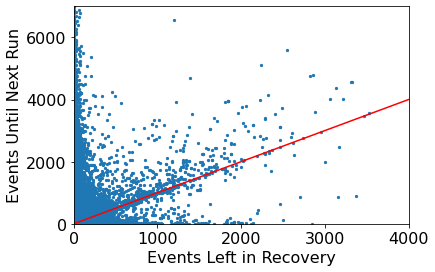

In [190]:
x_min = 0
x_max = 4000
y_min = 0
y_max = 7000

line = np.linspace(start=x_min, stop=x_max, num=100)
second_y = [x * 2 for x in line]

ax = switch_to_fail.plot.scatter(x='recovery_left', \
                            y='n_to_next_run', \
                            xlabel='Events Left in Recovery', \
                            ylabel='Events Until Next Run', \
                            xlim=(x_min, x_max),\
                            ylim=(y_min, y_max),\
                            s=5,\
                            )
plt.plot(line, line, '-r', label='y=x')
# plt.plot(line, second_y, '-r', label='y=1.5x')


In [191]:
ax.get_figure().savefig('./recovery_left_vs_next_run.png', bbox_inches='tight')
ax.get_figure().savefig('./recovery_left_vs_next_run.pdf', bbox_inches='tight')

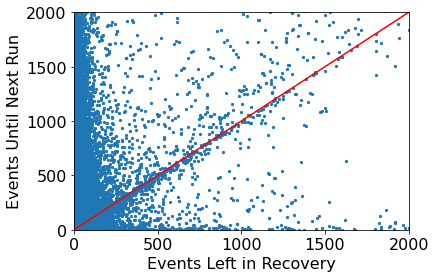

In [192]:
ax = switch_to_fail_2019.plot.scatter(x='recovery_left', \
                            y='n_to_next_run', \
                            xlabel='Events Left in Recovery', \
                            ylabel='Events Until Next Run', \
                            xlim=(x_min, 2000),\
                            ylim=(y_min, 2000),\
                            s=5,\
                            )
plt.plot(line, line, '-r', label='y=x')

In [193]:
ax.get_figure().savefig('./recovery_vs_run_2019.png', bbox_inches='tight')
ax.get_figure().savefig('./recovery_vs_run_2019.pdf', bbox_inches='tight')

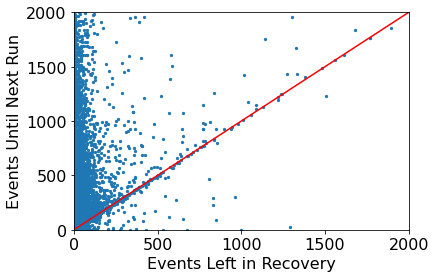

In [194]:
ax = switch_to_fail_2021.plot.scatter(x='recovery_left', \
                            y='n_to_next_run', \
                            xlabel='Events Left in Recovery', \
                            ylabel='Events Until Next Run', \
                            xlim=(x_min, 2000),\
                            ylim=(y_min, 2000),\
                            s=5,\
                            )
plt.plot(line, line, '-r', label='y=x')

In [195]:
ax.get_figure().savefig('./recovery_vs_run_2021.png', bbox_inches='tight')
ax.get_figure().savefig('./recovery_vs_run_2021.pdf', bbox_inches='tight')

This chart plots one dot for each event where a student whose program was in a compilable state no longer will compile.
It plots the number of events left before their program returns to a compilable state against the number of events left until the student runs their program.

The left side of the chart shows that many recoveries are quite small, which makes sense - as a student is typing, their program will frequently go in and out of a compilable state.

The events on roughly the line `y = x` are rather interesting, as they indicate instances where the student runs the program either just before or just after reaching a compilable state. A few possible sequences are possible -

- The student is unaware their program has an easy-to-fix syntax error. Upon completing the other section of code they are working on, they attempt to run the program, uncover the syntax error, and fix it quickly.
- The student knows they have a syntax error, they fix it and think that it is resolved, so they run their program to check that it is in fact resolved.

### Ratio - above vs below y=x line

In [196]:
switch_to_fail['above_line'] =  switch_to_fail['n_to_next_run'] / switch_to_fail['recovery_left']  > 1

In [197]:
subject_switch_to_fail = switch_to_fail.groupby('SubjectID')['above_line'].agg(['mean']).reset_index()\
    .rename({'mean': 'recovery_ratio'}, axis='columns')

In [198]:
subject_recovery_ratio = subject_switch_to_fail.merge(students, on='SubjectID').dropna(subset=['ExamAverage'])

In [199]:
print(len(subject_recovery_ratio))
subject_recovery_ratio.head()

530


,SubjectID,recovery_ratio,Unnamed: 0,index,Group,SyntaxExercises,p4,p5,p6,p7,...,Assign11,Assign12,Assign13,Exam1,Exam2,Exam3,FinalScore,Major,HighestACT,HighSchoolGPA
0,S001,0.967742,30,30,Spring,False,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S002,0.952145,333,333,Fall,True,90.0,90.0,86.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S004,0.992895,382,382,Fall,True,100.0,100.0,90.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S005,0.991071,328,328,Fall,True,95.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S006,0.962848,97,97,Spring,False,100.0,100.0,100.0,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


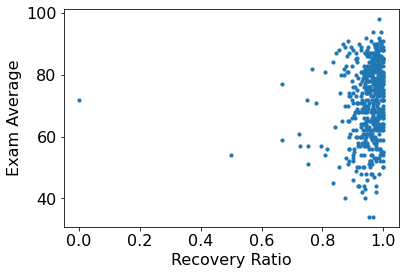

In [200]:
ax = subject_recovery_ratio.plot.scatter(x='recovery_ratio', y='ExamAverage', \
                                         xlabel='Recovery Ratio', ylabel='Exam Average',\
                                         s=10)

In [201]:
ax.get_figure().savefig('./recovery_ratio.svg')

In [202]:
pearsonr(subject_recovery_ratio['recovery_ratio'], subject_recovery_ratio['ExamAverage'])

(0.1422647203014335, 0.0010228465087037196)

In [203]:
print('Recoveries - all data')
calc_rel_to_line(switch_to_fail)
print('--------')
print('Recoveries - 2019 data')
calc_rel_to_line(switch_to_fail_2019)
print('--------')
print('Recoveries - 2021 data')
calc_rel_to_line(switch_to_fail_2021)

Recoveries - all data
Well above the line (m > 1.5): 148640 0.8870640471700365
Slightly above the line (1 < m <= 1.5): 12183 0.0727065479458595
Below the line (m < 1): 6741 0.04022940488410398
--------
Recoveries - 2019 data
Well above the line (m > 1.5): 112575 0.8759064454887803
Slightly above the line (1 < m <= 1.5): 10061 0.07828109924994553
Below the line (m < 1): 5888 0.04581245526127416
--------
Recoveries - 2021 data
Well above the line (m > 1.5): 36065 0.9237961065573771
Slightly above the line (1 < m <= 1.5): 2122 0.05435450819672131
Below the line (m < 1): 853 0.02184938524590164


In [204]:
recovery_ratio_2019 = subject_recovery_ratio[subject_recovery_ratio['semester'] == 'fall2019']

In [205]:
recovery_ratio_2021 = subject_recovery_ratio[subject_recovery_ratio['semester'] == 'fall2021']

In [206]:
print(len(recovery_ratio_2019))
print(len(recovery_ratio_2021))
print(len(subject_recovery_ratio))

490
40
530


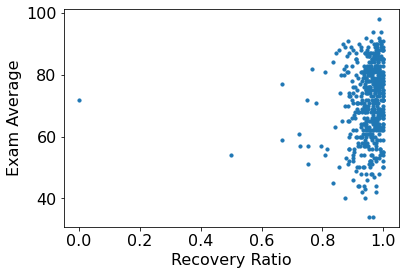

In [207]:
ax = recovery_ratio_2019.plot.scatter(x='recovery_ratio', y='ExamAverage', \
                                         xlabel='Recovery Ratio', ylabel='Exam Average',\
                                         s=10)

In [208]:
ax.get_figure().savefig('./recovery_ratio_2019.svg')

In [209]:
pearsonr(recovery_ratio_2019['recovery_ratio'], recovery_ratio_2019['ExamAverage'])

(0.12750598283356834, 0.004701525197627265)

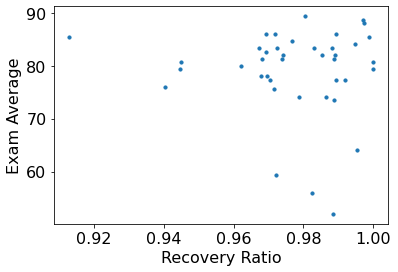

In [210]:
ax = recovery_ratio_2021.plot.scatter(x='recovery_ratio', y='ExamAverage', \
                                         xlabel='Recovery Ratio', ylabel='Exam Average',\
                                         s=10)

In [211]:
ax.get_figure().savefig('./recovery_ratio_2021.svg')

In [212]:
pearsonr(recovery_ratio_2021['recovery_ratio'], recovery_ratio_2021['ExamAverage'])

(-0.06829093133402331, 0.6754329535975815)

In [213]:
students[students['ExamAverage'].isnull()][['exam1', 'exam2', 'Exam1', 'Exam2', 'Exam3']].head()

,exam1,exam2,Exam1,Exam2,Exam3
160,NaN,NaN,NaN,NaN,NaN
582,NaN,NaN,NaN,NaN,NaN
583,NaN,NaN,NaN,NaN,NaN
584,NaN,NaN,NaN,NaN,NaN


## Can assignment complexity be determined by long recoveries?

Hypothesis: the number (or frequency) of long recoveries in an assignment provides an indication of how complex (or difficult) the assignment is.

In [214]:
threshold = 25

In [215]:
assignment_df = create_assignment_df(events)
assignment_df = add_instance_length_stats(events, assignment_df)
assignment_df = add_median_recoveries_above_threshold(threshold, events, assignment_df)

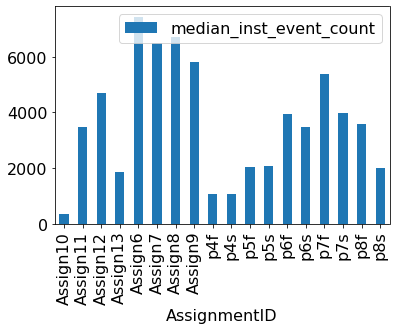

In [216]:
fig = assignment_df.plot.bar(x='AssignmentID', y='median_inst_event_count')

In [217]:
fig.get_figure().savefig('./median_inst_event_count.svg')

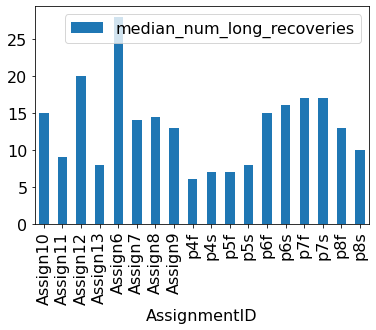

In [218]:
fig = assignment_df.plot.bar(x='AssignmentID', y='median_num_long_recoveries')

In [219]:
fig.get_figure().savefig('./median_num_long_recoveries.svg')

The assignments Assign6 - Assign12 are from the 2021 data and assignments p4f - p8s are from the 2019 data.

It appears that, at least for the 2019 data, the assignment complexity (as measured by average number of long recoveries per student) steadily increased over the course of the semester. Conceptually, this makes sense - as the professor builds a foundation and moves to more complex topics, the assignment complexity increases to match. 

<AxesSubplot:xlabel='median_num_long_recoveries', ylabel='median_inst_event_count'>

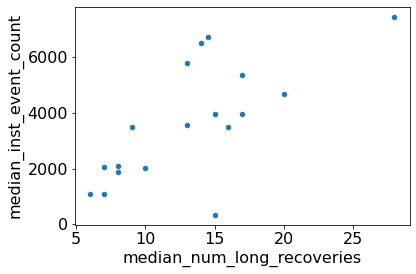

In [220]:
assignment_df.plot.scatter(x='median_num_long_recoveries',\
                           y='median_inst_event_count')

In [221]:
assignment_df['recovery_ratio'] = assignment_df['median_num_long_recoveries'] / assignment_df['median_inst_event_count']

In [222]:
assignment_df['recovery_ratio'].head()

0    0.043228
1    0.002588
2    0.004262
3    0.004284
4    0.003766
Name: recovery_ratio, dtype: float64

In [223]:
instance_df = create_instance_df(events)
instance_df = add_recoveries_above_threshold_count(threshold, events, instance_df)

In [224]:
instance_df.head()

,AssignmentID,SubjectID,event_count,num_long_recoveries
0,Assign10,Student1,279,NaN
1,Assign10,Student10,11164,44.0
2,Assign10,Student12,192,NaN
3,Assign10,Student16,3490,15.0
4,Assign10,Student18,448,NaN


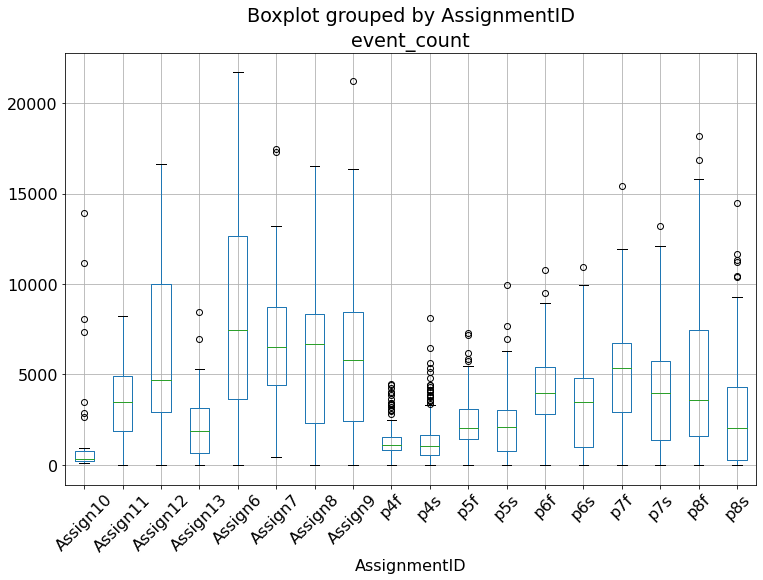

In [225]:
fig, ax = plt.subplots(figsize=(12,8))
instance_df.boxplot(column='event_count', by='AssignmentID', ax=ax, rot=45)
plt.show()

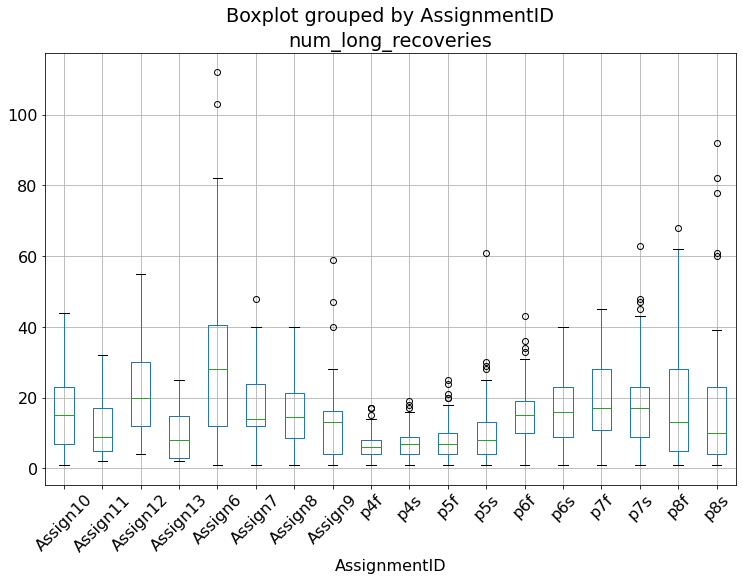

In [226]:
fig, ax = plt.subplots(figsize=(12,8))
instance_df.boxplot(column='num_long_recoveries', by='AssignmentID', ax=ax, rot=45)
plt.show()

In [229]:
ax.get_figure().savefig('./long_recoveries_per_assignment.svg')

In [230]:
instance_df['recoveries_per_10k_events'] = instance_df['num_long_recoveries'] / (instance_df['event_count'] / 10000)

In [231]:
positions= [x for x in range(8, 18)] + [x for x in range(8)]
print(len(instance_df.AssignmentID.unique()))
print(len(positions))

18
18


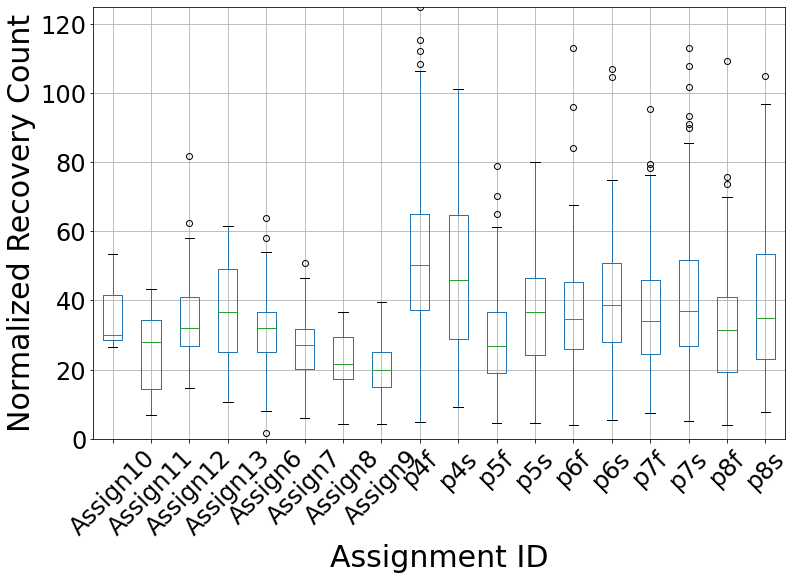

In [232]:
font_size = 30
tick_font_size = 24
positions= [x for x in range(8, 18)] + [x for x in range(8)]
fig, ax = plt.subplots(figsize=(12,8))
instance_df.boxplot(column='recoveries_per_10k_events', by='AssignmentID', ax=ax, rot=45)
ax.set_ylim((0, 125))
ax.set_title('')
plt.suptitle('')
ax.set_xlabel("Assignment ID", fontsize=font_size);
ax.set_ylabel("Normalized Recovery Count", fontsize=font_size);
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(tick_font_size)
plt.show()

In [236]:
ax.get_figure().savefig(f'./dist_of_long_recoveries.svg')

In [237]:
events[events['recovery_start'] == True]

,unnamed_zero,EventID,SubjectID,AssignmentID,CodeStateSection,X-Task,EventType,X-Keystroke,InsertText,DeleteText,...,fail_switch_rate,place_in_task_bin,binary_run,known_recovery,ktest,ktest2,ktest3,test,test2,test3
35,1925,1926,S001,p4s,task1.py,1.0,File.Edit,"""","""",NaN,...,1,"(0.6, 0.7]",0,0,True,1,1,True,1,1
39,1929,1930,S001,p4s,task1.py,1.0,File.Edit,"""","""",NaN,...,1,"(0.8, 0.9]",0,0,True,1,3,True,1,3
52,1953,1957,S001,p5s,task0.py,0.0,File.Edit,n,n,NaN,...,1,"(0.0, 0.1]",0,0,True,1,5,True,1,5
217,2080,2095,S001,p5s,task1.py,1.0,File.Edit,d,d,\n#Convert t,...,1,"(0.0, 0.1]",0,0,True,1,7,True,1,7
264,2127,2142,S001,p5s,task1.py,1.0,File.Edit,=,=,NaN,...,1,"(0.1, 0.2]",0,0,True,1,9,True,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110941,1991307,1991307,Student8,Assign9,junk.py,NaN,File.Edit,NaN,(,NaN,...,1,"(0.5, 0.6]",0,0,True,1,331218,True,1,331218
6110944,1991310,1991310,Student8,Assign9,junk.py,NaN,File.Edit,NaN,"""",NaN,...,1,"(0.5, 0.6]",0,0,True,1,331220,True,1,331220
6111014,1998444,1998444,Student8,Assign9,task2.py,NaN,File.Edit,NaN,(,NaN,...,1,"(0.1, 0.2]",0,0,True,1,331222,True,1,331222
6111025,1998455,1998455,Student8,Assign9,task2.py,NaN,File.Edit,NaN,NaN,),...,1,"(0.3, 0.4]",0,0,True,1,331224,True,1,331224


- Average exams scores for the different years
- Are there outcomes that are impacted by the difference in syntax highlighting?
Changes in the population
- Average per each assignment, change in recoveries between assignments
- Student level - above or below the assignment average for long recoveries, event count, etc. 
Are these metrics consistent across assignments for most students? Or are some assignments disproportionatly hard for certain students and easier for others?

#### Why does Assignment 6 tend to have a larger quantity of long recoveries than the other assignments?

In [ ]:
# assign_6_recoveries = recoveries_above_threshold[recoveries_above_threshold.AssignmentID == 'Assign6']

In [ ]:
# assign_6_recoveries.recovery_left.plot(kind="hist", loglog=True, figsize=(7, 3))

In [ ]:
# which students had the greatest number of long recoveries?
# recoveries_agg[recoveries_agg.AssignmentID == 'Assign6'].sort_values(by=['count'], ascending=False, ignore_index=True).head(10)

TODO
- [x] Build some reusable functions to retrieve common info
  - Which students had the longest recoveries for a given assignment?
  - How did the recovery metrics vary across the assignments?

### Spacer

In [238]:
syntax_error_runs = events[(events.EventType == 'Run.Program') & (events.would_compile == False)]

<AxesSubplot:title={'center':'Non-compiling Run Events - Recovery vs Next Run'}, xlabel='Events Left in Recovery', ylabel='Events Until Next Run'>

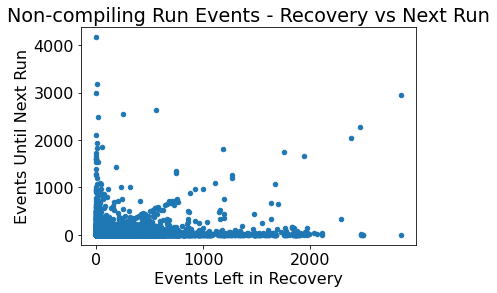

In [239]:
syntax_error_runs.plot.scatter(x='recovery_left', \
                               y='n_to_next_run', \
                               xlabel='Events Left in Recovery', \
                               ylabel='Events Until Next Run', \
                               title='Non-compiling Run Events - Recovery vs Next Run')

<AxesSubplot:title={'center':'Non-compiling Run Events - Recovery vs Next Successful Run'}, xlabel='Events Left in Recovery', ylabel='Events Until Next Successful Run'>

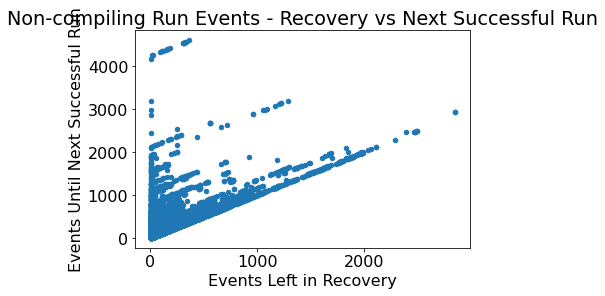

In [240]:
syntax_error_runs.plot.scatter(x='recovery_left', \
                               y='n_to_successful_run', \
                               xlabel='Events Left in Recovery', \
                               ylabel='Events Until Next Successful Run', \
                               title='Non-compiling Run Events - Recovery vs Next Successful Run')

In [241]:
assign_recovery_left = events.groupby(['AssignmentID'])['recovery_left'].agg(['count', 'mean', 'median']).reset_index()

In [242]:
assign_recovery_left.head(10)

,AssignmentID,count,mean,median
0,Assign10,57394,7.414416,0.0
1,Assign11,105136,18.997784,0.0
2,Assign12,197097,77.486573,0.0
3,Assign13,54053,35.409912,0.0
4,Assign6,339676,50.683781,0.0
5,Assign7,236960,63.916969,0.0
6,Assign8,192427,110.780280,0.0
7,Assign9,194018,444.185034,16.0
8,p4f,220365,28.697643,0.0
9,p4s,234985,24.446220,0.0


<AxesSubplot:title={'center':'Recovery predicting total work in assignment'}, xlabel='Average recovery left from event', ylabel='Events in assignment'>

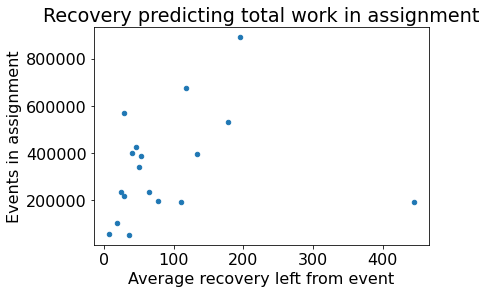

In [243]:
assign_recovery_left.plot.scatter(x='mean', y='count', \
                                 xlabel='Average recovery left from event', \
                                 ylabel='Events in assignment',\
                                 title='Recovery predicting total work in assignment')

In [244]:
pearsonr(assign_recovery_left['mean'], assign_recovery_left['count'])

(0.21373260424253154, 0.39443855265046907)

- Switch assignment analysis to switch to fail events, look at the median again
- Remove outlier, re-run pearsonr
- Interquartile range - outside may indicate struggling
  - Test for outliers - Rosner’s Extreme Studentized Deviate test
- Switch Events in assignment to Median events in assignment per student

New file:
- X-File changed

CodeStateSection->SourceLocation and X-File->CodeStateSection (filename)
New Grades file - match SubjectId



## Ready-to-work Potential TODOs

- [ ] Create threshold for min number of keystrokes in file to consider, remove short files
  - Probably not that useful, since a file recreation problem causes the whole file to be thrown out
- [x] Analyze Recovery Left vs Count to Next _Successful_ Run
  - [x] Add column for count to next successful run
  - [x] Plot recovery left vs count to next successful run
- [x] Start Overleaf Document

### Potential TODOs and Things to Consider

- [x] Look at recoveries from individual assignments
  - [x] Average recovery length per assignment - metric for assignment complexity
- Analytical understanding - student psychology while programming
- Comparing Java and Python for how much time in a compilable state
- Lab study - looking at how students change how they write based on whether they are in a "compilable state"
- Attitude towards errors - fix things as you go vs fix things at the end

- Check for library to check for grammer errors
- Compare the 2019 and 2021 data - distribution of what character was typed to put them in an uncompilable state
  - Do auto-close things impact metrics
- Compute the amount of time they spent in an uncompilable state
  - Breaks during recovery

- TODO add in cohen's d statistic
- recovery time from an error 
- DONE 4 shifts - compilable vs non-compilable square
- how many consecutive non-compilable keystrokes until you research a compilable state
- catogorize tokens vs comments vs whitespace
- TODO walk through more playbacks

target - use the every-keystroke compile rate to correct for someone who runs the program, has an error,
corrects the error, and then doesn't run again

Next steps: 
1. see if the compile rate is different depending on whether the last run would compile
2. walk backward through the events, giving a n_to_next_compilable_run value

## Data Integrity

- Add index as a final sorting filter to filter_sort.py - DONE
  - Retest to check discard rate - DONE - 13.7%
- Add users to filter_sort - DONE
- Only throw out until setValue resets file state

## 3 states

Known would not compile
Unknown would not compile
Would compile

## Splitting means

Come up with the most accurate difference I can between the compile rate means of the two groups

## Less Useful Charts

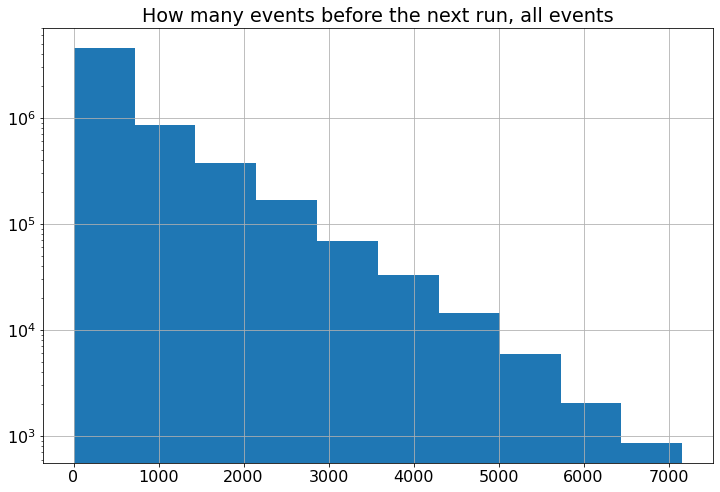

In [245]:
fig, ax = plt.subplots(figsize=(12,8))
events.hist(column='n_to_next_run', ax=ax)
ax.set_yscale('log')
plt.title('How many events before the next run, all events')
plt.show()

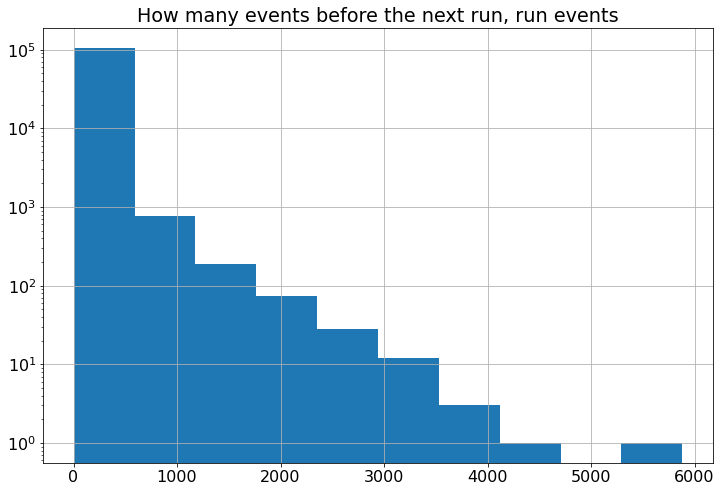

In [246]:
fig, ax = plt.subplots(figsize=(12,8))
run_events.hist(column='n_to_next_run', ax=ax)
ax.set_yscale('log')
plt.title('How many events before the next run, run events')
plt.show()